# DRUGBANK GraphSynergy Toxicity Score Analysis #

- GraphSynergy paper can be found here: https://academic.oup.com/jamia/article/28/11/2336/6362567?login=true#305111898

In [1]:
# Import everything needed
from matplotlib.patches import Patch
from scipy import stats
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from toxicity_ranking import *
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import seaborn as sns

GraphSynergy creates toxicity score embeddings by:
1. Aggregating the all neighbors within 2 degrees of drugs' two_hop proteins on a PPIN
2. Creating a similarity score by computing the inner product of drug embeddings

So let's examine each of these options in how well toxicity category distributions are (Kruskal Wallis) and if there is a relationship in increasing order with the toxicity categories (Jonckheere Terpestra Test)

In [2]:
# Get the STRING database and read it into a graph

string_edge_list_df = pd.read_csv('data/STRING/9606.protein.physical.links.detailed.v12.0.txt', sep=' ')
print(string_edge_list_df.shape)
string_edge_list_df.drop(columns=['database','textmining','combined_score'], inplace=True)
string_edge_list_df = string_edge_list_df[string_edge_list_df['experimental'] != 0]
print(string_edge_list_df.shape)
STRING_G = nx.from_pandas_edgelist(string_edge_list_df, 'protein1', 'protein2')
STRING_G = STRING_G.to_undirected()
print(STRING_G.number_of_edges())


(1477610, 6)
(1182858, 3)
591429


In [3]:
# Get all the drug combinations
drug_combos_df = pd.read_csv('data_processed/drugbank_filtered_combos_syntox_known_targallpw.csv')
syntoxtarg_df = pd.read_csv('data_processed/drugbank_syntoxtarg.csv')
# Get STRING ID mapping
uniprot_to_string = {}
with open('data_processed/uniprot_id_to_string_mapping_2025_01_24.tsv', 'r') as f:
    f.readline()
    for lines in f:
        uniprot_id, string_id = lines.strip('\n').split('\t')
        uniprot_to_string[uniprot_id] = string_id
with open('data_processed/drugbank_leftovers_uniprot_string_mapping_2025_02_14.tsv', 'r') as f:
    f.readline() # skip header
    f.readline() # skip nan
    for lines in f:
        entry = lines.strip('\n').split('\t')
        uniprot_id = entry[1]
        string_id = entry[2]
        uniprot_to_string[uniprot_id] = string_id
syntoxtarg_df['STRING_ID'] = syntoxtarg_df['UniProtKB_ID'].map(uniprot_to_string)
# Add one genebank ID that was missing
syntoxtarg_df.loc[syntoxtarg_df['GenBank_Gene_ID'] == 'AJ251501', 'STRING_ID'] = '9606.ENSP00000365437'

# NOTE: Not all proteins have STRING IDs


In [4]:
# Create a dataframe of drug combinations and their targets as well as the targets' neighbors within 2 hops
drug_combos_within_2_hops = {}
for index, row in drug_combos_df.iterrows():
    drugA = row['drug_row']
    drugB = row['drug_col']
    key = (drugA, drugB)
    if key not in drug_combos_within_2_hops:
        A_targets = set(syntoxtarg_df[syntoxtarg_df['drug_name'] == drugA]['STRING_ID'].dropna().values)
        B_targets = set(syntoxtarg_df[syntoxtarg_df['drug_name'] == drugB]['STRING_ID'].dropna().values)
        if len(A_targets) == 0 or len(B_targets) == 0: # There are no STRING IDs for the targets
            continue
        A_neighbors = set()
        B_neighbors = set()
        for target in A_targets:
            if target in STRING_G.nodes:
                A_neighbors.update(STRING_G.neighbors(target))
        for target in B_targets:
            if target in STRING_G.nodes:
                B_neighbors.update(STRING_G.neighbors(target))
        A_2nd_neighbors = set()
        B_2nd_neighbors = set()
        for neighbor in A_neighbors:
            if neighbor in STRING_G.nodes:
                A_2nd_neighbors.update(STRING_G.neighbors(neighbor))
        for neighbor in B_neighbors:
            if neighbor in STRING_G.nodes:
                B_2nd_neighbors.update(STRING_G.neighbors(neighbor))
        
        drug_combos_within_2_hops[(drugA, drugB)] = {
            'A_targets': A_targets,
            'B_targets': B_targets,
            'A_neighbors': A_neighbors,
            'B_neighbors': B_neighbors,
            'A_2nd_neighbors': A_2nd_neighbors,
            'B_2nd_neighbors': B_2nd_neighbors
        }

In [6]:
# For each drug combination, compute the jaccard similarity between the sets of neighborhood proteins of drug A and drug B
for index, row in drug_combos_df.iterrows():
    key = (row['drug_row'], row['drug_col'])
    # Get the full set of proteins within 2 hops of drug A and drug B
    if key not in drug_combos_within_2_hops:
        drug_combos_df.at[index, 'two_hop_jaccard'] = np.nan
        continue
    
    A_full_within_2_hops = drug_combos_within_2_hops[key]['A_targets'].union(drug_combos_within_2_hops[key]['A_neighbors']).union(drug_combos_within_2_hops[key]['A_2nd_neighbors'])
    B_full_within_2_hops = drug_combos_within_2_hops[key]['B_targets'].union(drug_combos_within_2_hops[key]['B_neighbors']).union(drug_combos_within_2_hops[key]['B_2nd_neighbors'])
    
    two_hop_jaccard = jaccard_similarity(A_full_within_2_hops, B_full_within_2_hops)
    drug_combos_df.at[index, 'two_hop_jaccard'] = two_hop_jaccard
    
drug_combos_df.head()

# Print how many combinations have a valid Jaccard similarity
print(drug_combos_df['two_hop_jaccard'].notnull().sum())

72814


(array([  990.,  1560.,  1952.,  1324.,  2664.,  3163.,  4047.,  3201.,
         1295.,  2710.,  4696.,  3224.,  4602.,  8926., 13154.,  5622.,
         4605.,  4276.,    62.,   741.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

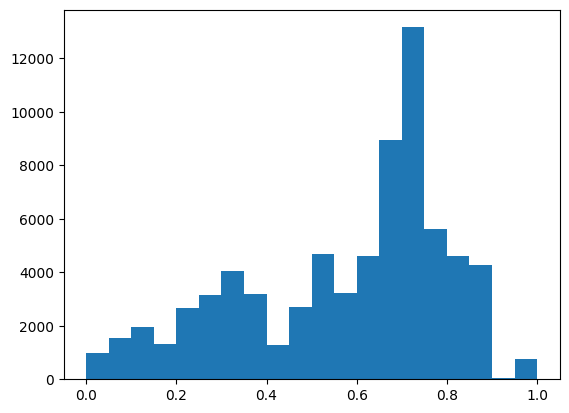

In [7]:
plt.hist(drug_combos_df['two_hop_jaccard'], bins=20)

- Kruskal Wallis Test
- Dunn Posthoc Test with Bonferroni Correction
- Jonckheere Terpestra Test
- ANOVA
- T Test with Bonferroni Correction

In [8]:
# Run Kruskal Wallis test on jaccard similarities with targeting Major, Moderate, and Minor toxicity

# two_hop jaccard
major_twohop = drug_combos_df[drug_combos_df['toxicity_category'] == 'Major']['two_hop_jaccard'].dropna()
moderate_twohop = drug_combos_df[drug_combos_df['toxicity_category'] == 'Moderate']['two_hop_jaccard'].dropna()
minor_twohop = drug_combos_df[drug_combos_df['toxicity_category'] == 'Minor']['two_hop_jaccard'].dropna()
print(f'Major two_hop jaccard: {len(major_twohop)}')
print(f'Moderate two_hop jaccard: {len(moderate_twohop)}')
print(f'Minor two_hop jaccard: {len(minor_twohop)}')

h_statistic_twohop_tox, p_value_twohop_tox = stats.kruskal(major_twohop, moderate_twohop, minor_twohop)
print(f'Kruskal-Wallis H statistic for two_hop jaccard: {h_statistic_twohop_tox}')
print(f'P-value for two_hop jaccard: {p_value_twohop_tox}')

# Filter drug_combos_df for only Major, Moderate, and Minor toxicity categories and remove pairs with two_hop jaccard similarity of None
drug_combos_df_tox_twohop = drug_combos_df[drug_combos_df['toxicity_category'].isin(['Major', 'Moderate', 'Minor'])]
drug_combos_df_tox_twohop = drug_combos_df[~drug_combos_df_tox_twohop['two_hop_jaccard'].isnull()]
dunn_twohop_tox = sp.posthoc_dunn(drug_combos_df_tox_twohop, val_col='two_hop_jaccard', group_col='toxicity_category', p_adjust='bonferroni')
print('Dunn post-hoc test for two_hop jaccard:' + str(dunn_twohop_tox))

# jonkcheere terpestra test -- is there a trend in the overlap (jaccard similarity) as you increase toxicity from minor to major?
jaccard_major_samples = major_twohop.values.tolist()
jaccard_moderate_samples = moderate_twohop.values.tolist()
jaccard_minor_samples = minor_twohop.values.tolist()
jt_incr_twohop = jonckheere_terpestra_test([jaccard_minor_samples, jaccard_moderate_samples, jaccard_major_samples])
print("Increasing toxicity for two_hop overlap: ", jt_incr_twohop )
jt_decr_twohop = jonckheere_terpestra_test([jaccard_major_samples, jaccard_moderate_samples, jaccard_minor_samples])
print("Decreasing toxicity for two_hop overlap: ", jt_decr_twohop)

# Run an ANOVA on two_hop jaccard similarity for Major, Moderate, and Minor toxicity categories
f_statistic_anova_twohop_tox, p_value_anova_twohop_tox = stats.f_oneway(major_twohop, moderate_twohop, minor_twohop)
print(f'ANOVA F-statistic for two_hop jaccard similarity: {f_statistic_anova_twohop_tox}')
print(f'P-value for two_hop jaccard similarity: {p_value_anova_twohop_tox}')

# Run a T test on two_hop jaccard similarity between Major/Minor, Major/Moderate, and Moderate/Minor toxicity categories
major_minor_twohop = stats.ttest_ind(major_twohop, minor_twohop)
major_moderate_twohop = stats.ttest_ind(major_twohop, moderate_twohop)
moderate_minor_twohop = stats.ttest_ind(moderate_twohop, minor_twohop)

# Run bonferroni correction on the p-values
ttest_p_values = [major_minor_twohop[1], major_moderate_twohop[1], moderate_minor_twohop[1]]
ttest_p_values_corrected = multipletests(ttest_p_values, method='bonferroni')
print(f'Major/Minor T-test: {major_minor_twohop[1]} Corrected: {ttest_p_values_corrected[1][0]}')
print(f'Major/Moderate T-test: {major_moderate_twohop[1]} Corrected: {ttest_p_values_corrected[1][1]}')
print(f'Moderate/Minor T-test: {moderate_minor_twohop[1]} Corrected: {ttest_p_values_corrected[1][2]}')


with open('results/two_hop_analysis/two_hop_targ_jaccard_drugbank.tsv', 'w') as f:
    f.write('Level\tTest\tTest statistic\tP-value\n')
    f.write(f'Two-Hop\tKruskal-Wallis\t{h_statistic_twohop_tox}\t{p_value_twohop_tox}\n')
    f.write(f'Two-Hop\tDunn post-hoc\tMajor/Minor\t{dunn_twohop_tox.iloc[0,1]}\n')
    f.write(f'Two-Hop\tDunn post-hoc\tMajor/Moderate\t{dunn_twohop_tox.iloc[0, 2]}\n')
    f.write(f'Two-Hop\tDunn post-hoc\tModerate/Minor\t{dunn_twohop_tox.iloc[1, 2]}\n')
    f.write(f'Two-Hop\tJonckheere-Terpstra Increasing toxicity\t{jt_incr_twohop[0]}\t{jt_incr_twohop[1]}\n')
    f.write(f'Two-Hop\tJonckheere-Terpstra Decreasing toxicity\t{jt_decr_twohop[0]}\t{jt_decr_twohop[1]}\n')
    f.write(f'Two-Hop\tANOVA\t{f_statistic_anova_twohop_tox}\t{p_value_anova_twohop_tox}\n')
    f.write(f'Two-Hop\tT-test (bonf cor)\tMajor/Minor\t{ttest_p_values_corrected[1][0]}\n')
    f.write(f'Two-Hop\tT-test (bonf cor)\tMajor/Moderate\t{ttest_p_values_corrected[1][1]}\n')
    f.write(f'Two-Hop\tT-test (bonf cor)\tModerate/Minor\t{ttest_p_values_corrected[1][2]}\n')

Major two_hop jaccard: 44138
Moderate two_hop jaccard: 21248
Minor two_hop jaccard: 7428
Kruskal-Wallis H statistic for two_hop jaccard: 4229.232243944245
P-value for two_hop jaccard: 0.0
Dunn post-hoc test for two_hop jaccard:          Major         Minor      Moderate
Major       1.0  0.000000e+00  0.000000e+00
Minor       0.0  1.000000e+00  1.014900e-90
Moderate    0.0  1.014900e-90  1.000000e+00
Increasing toxicity for two_hop overlap:  (64.36909430172216, 0.0)
Decreasing toxicity for two_hop overlap:  (-64.36909430172216, 1.0)
ANOVA F-statistic for two_hop jaccard similarity: 2834.519762870652
P-value for two_hop jaccard similarity: 0.0
Major/Minor T-test: 0.0 Corrected: 0.0
Major/Moderate T-test: 0.0 Corrected: 0.0
Moderate/Minor T-test: 9.835074571115683e-71 Corrected: 2.950522371334705e-70


- Violin Plot

In [9]:
colors = ['#20965D', '#FFBC42', '#D81159']
tox_order = ['Minor', 'Moderate', 'Major']
color_dict = dict(zip(tox_order, colors))
legend_elements = [
    Patch(facecolor=color_dict[cat], label = cat) for cat in tox_order
]

ax = sns.violinplot(data=drug_combos_df, x='toxicity_category', y='two_hop_jaccard', palette=color_dict, hue='toxicity_category', order=tox_order)
ax.set_xlabel('')
ax.set_ylabel('Neighboring Proteins within 2 Hops Jaccard Similarity')
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5,-0.2), loc='center', ncol=3)
plt.tight_layout()
plt.savefig('results/two_hop_analysis/twohop_js_v_toxcatwohop_drugbank_violin.png', dpi=700)
plt.close()

- Strip Plot

In [10]:
ax = sns.stripplot(data=drug_combos_df, x='toxicity_category', y='two_hop_jaccard', palette=color_dict, hue='toxicity_category', order=tox_order)
ax.set_xlabel('')
ax.set_ylabel('Neighboring Proteins within 2 Hops Jaccard Similarity')
plt.legend(handles=legend_elements, bbox_to_anchor=(0.5,-0.2), loc='center', ncol=3)
plt.tight_layout()
plt.savefig('results/two_hop_analysis/twohop_js_v_toxcatwohop_drugbank_strip.png', dpi=700)
plt.close()

- Correlation Scatter Plots (Neighboring Proteins withing 2 Hops Jaccard Similarity v Synergy Scores)
- R^2 value
- Best fit line
- Pearson correlation coefficient
- Spearman correlation coefficient

In [13]:
# Drop all rows with NaN values in the two_hop_jaccard column
drug_combos_df.dropna(subset=['two_hop_jaccard'], inplace=True)

x_twohop = drug_combos_df['two_hop_jaccard']
y_bliss_true = drug_combos_df['synergy_bliss']
y_loewe_true = drug_combos_df['synergy_loewe']
y_hsa_true = drug_combos_df['synergy_hsa']
y_zip_true = drug_combos_df['synergy_zip']


####### BLISS ########
# Let's plot two hop jaccard similarity against bliss synergy scores
plt.scatter(x_twohop, y_bliss_true)

# Best fit line
z_twohop_bliss = np.polyfit(x_twohop, y_bliss_true, 1)
p_twohop_bliss = np.poly1d(z_twohop_bliss)
y_bliss_pred = p_twohop_bliss(x_twohop)
r_squared_twohop_bliss = r2_score(y_bliss_true, y_bliss_pred)
plt.plot(x_twohop, y_bliss_pred, "r-", alpha=0.8, label=f'y = {z_twohop_bliss[0]:.3f}x + {z_twohop_bliss[1]:.3f}\nR² = {r_squared_twohop_bliss:.3f}')

plt.xlabel('Neighboring Proteins within 2 Hops Jaccard Similarity')
plt.ylabel('Bliss Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/two_hop_analysis/bliss_v_twohop_drugbank_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between two hop jaccard similarity and bliss synergy score
two_hop_bliss_corr = x_twohop.corr(y_bliss_true)
print(f'Pearson correlation coefficient between two hop jaccard similarity and bliss synergy score: {two_hop_bliss_corr}')

# Calculate Spearman correlation coefficient between two hop jaccard similarity and bliss synergy score
two_hop_bliss_spearman_corr = x_twohop.corr(y_bliss_true, method='spearman')
print(f'Spearman correlation coefficient between two hop jaccard similarity and bliss synergy score: {two_hop_bliss_spearman_corr}')

####### HSA ########
# Let's plot two hop jaccard similarity against hsa synergy scores
plt.scatter(x_twohop, y_hsa_true)

# Best fit line
z_twohop_hsa = np.polyfit(x_twohop, y_hsa_true, 1)
p_twohop_hsa = np.poly1d(z_twohop_hsa)
y_hsa_pred = p_twohop_hsa(x_twohop)
r_squared_twohop_hsa = r2_score(y_hsa_true, y_hsa_pred)
plt.plot(x_twohop, y_hsa_pred, "r-", alpha=0.8, label=f'y = {z_twohop_hsa[0]:.3f}x + {z_twohop_hsa[1]:.3f}\nR² = {r_squared_twohop_hsa:.3f}')

plt.xlabel('Neighboring Proteins within 2 Hops Jaccard Similarity')
plt.ylabel('HSA Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/two_hop_analysis/hsa_v_twohop_drugbank_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between two hop jaccard similarity and hsa synergy score
two_hop_hsa_corr = x_twohop.corr(y_hsa_true)
print(f'Pearson correlation coefficient between two hop jaccard similarity and hsa synergy score: {two_hop_hsa_corr}')

# Calculate Spearman correlation coefficient between two hop jaccard similarity and hsa synergy score
two_hop_hsa_spearman_corr = x_twohop.corr(y_hsa_true, method='spearman')
print(f'Spearman correlation coefficient between two hop jaccard similarity and hsa synergy score: {two_hop_hsa_spearman_corr}')

####### LOEWE ########
# Let's plot two hop jaccard similarity against loewe synergy scores
plt.scatter(x_twohop, y_loewe_true)

# Best fit line
z_twohop_loewe = np.polyfit(x_twohop, y_loewe_true, 1)
p_twohop_loewe = np.poly1d(z_twohop_loewe)
y_loewe_pred = p_twohop_loewe(x_twohop)
r_squared_twohop_loewe = r2_score(y_loewe_true, y_loewe_pred)
plt.plot(x_twohop, y_loewe_pred, "r-", alpha=0.8, label=f'y = {z_twohop_loewe[0]:.3f}x + {z_twohop_loewe[1]:.3f}\nR² = {r_squared_twohop_loewe:.3f}')

plt.xlabel('Neighboring Proteins within 2 Hops Jaccard Similarity')
plt.ylabel('Loewe Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/two_hop_analysis/loewe_v_twohop_drugbank_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between two hop jaccard similarity and loewe synergy score
two_hop_loewe_corr = x_twohop.corr(y_loewe_true)
print(f'Pearson correlation coefficient between two hop jaccard similarity and loewe synergy score: {two_hop_loewe_corr}')

# Calculate Spearman correlation coefficient between two hop jaccard similarity and loewe synergy score
two_hop_loewe_spearman_corr = x_twohop.corr(y_loewe_true, method='spearman')
print(f'Spearman correlation coefficient between two hop jaccard similarity and loewe synergy score: {two_hop_loewe_spearman_corr}')

####### ZIP ########
# Let's plot two hop jaccard similarity against zip synergy scores
plt.scatter(x_twohop, y_zip_true)

# Best fit line
z_twohop_zip = np.polyfit(x_twohop, y_zip_true, 1)
p_twohop_zip = np.poly1d(z_twohop_zip)
y_zip_pred = p_twohop_zip(x_twohop)
r_squared_twohop_zip = r2_score(y_zip_true, y_zip_pred)
plt.plot(x_twohop, y_zip_pred, "r-", alpha=0.8, label=f'y = {z_twohop_zip[0]:.3f}x + {z_twohop_zip[1]:.3f}\nR² = {r_squared_twohop_zip:.3f}')

plt.xlabel('Neighboring Proteins within 2 Hops Jaccard Similarity')
plt.ylabel('ZIP Synergy Score')
plt.legend()
plt.tight_layout()
plt.savefig('results/two_hop_analysis/zip_v_twohop_drugbank_scatter.png', dpi=700)
plt.close()

# Calculate Pearson correlation coefficient between two hop jaccard similarity and zip synergy score
two_hop_zip_corr = x_twohop.corr(y_zip_true)
print(f'Pearson correlation coefficient between two hop jaccard similarity and zip synergy score: {two_hop_zip_corr}')

# Calculate Spearman correlation coefficient between two hop jaccard similarity and zip synergy score
two_hop_zip_spearman_corr = x_twohop.corr(y_zip_true, method='spearman')
print(f'Spearman correlation coefficient between two hop jaccard similarity and zip synergy score: {two_hop_zip_spearman_corr}')

# Write all the correlations and spearman correlations to a file
with open('results/two_hop_analysis/two_hop_v_synergy_correlations_drugbank.tsv', 'w') as f:
    f.write('Synergy score\tLevel\tPearson correlation coefficient\tSpearman correlation\tR squared value\n')
    f.write(f'Bliss\tNeighboring Proteins within 2 Hop Jaccard Similarity\t{two_hop_bliss_corr}\t{two_hop_bliss_spearman_corr}\t{r_squared_twohop_bliss}\n')
    f.write(f'HSA\tNeighboring Proteins within 2 Hop Jaccard Similarity\t{two_hop_hsa_corr}\t{two_hop_hsa_spearman_corr}\t{r_squared_twohop_hsa}\n')
    f.write(f'Loewe\tNeighboring Proteins within 2 Hop Jaccard Similarity\t{two_hop_loewe_corr}\t{two_hop_loewe_spearman_corr}\t{r_squared_twohop_loewe}\n')
    f.write(f'ZIP\tNeighboring Proteins within 2 Hop Jaccard Similarity\t{two_hop_zip_corr}\t{two_hop_zip_spearman_corr}\t{r_squared_twohop_zip}\n')

Pearson correlation coefficient between two hop jaccard similarity and bliss synergy score: 0.130270541777289
Spearman correlation coefficient between two hop jaccard similarity and bliss synergy score: 0.13471805553340546
Pearson correlation coefficient between two hop jaccard similarity and hsa synergy score: 0.0578336413479267
Spearman correlation coefficient between two hop jaccard similarity and hsa synergy score: 0.14868423331308708
Pearson correlation coefficient between two hop jaccard similarity and loewe synergy score: 0.007701712896577345
Spearman correlation coefficient between two hop jaccard similarity and loewe synergy score: 0.06739566394372215
Pearson correlation coefficient between two hop jaccard similarity and zip synergy score: 0.17955310954434636
Spearman correlation coefficient between two hop jaccard similarity and zip synergy score: 0.16321242670299863
